In [1]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm 
import torch.nn.functional as Func

In [2]:
class Expert(nn.Module):
    def __init__(self, input_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 800)
        self.fc4 = nn.Linear(800,1)
        self.sigmoid = nn.Sigmoid()
        self.elu=Func.elu
        self.batch = nn.BatchNorm1d(800)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
  

class Gating(nn.Module):
    def __init__(self, input_size, num_experts):
        super(Gating, self).__init__()
        self.fc1 = nn.Linear(input_size, num_experts)
        self.SftMax = nn.functional.softmax

    def forward(self, x):
        x = self.SftMax(self.fc1(x))
        # print("X value",x)
        return x
  

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Expert_model = Expert(32*32*3).to(device)


In [36]:
# from torch._C import float32
def train(model,optimizer,loss_function,device,train_data,Gamma=5):
  correct_train_pred = 0
  total_samples = 0
  total_batches = 0 
  for i, (images, labels) in enumerate(train_data):


    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = torch.tensor(labels,dtype=torch.float32).to(device)
    # labels = labels.to(device)
    outputs = model(images)
    # print("OP",outputs)
    

    loss = loss_function(outputs,labels)

    optimizer.zero_grad()
    # print(type(labels[0].item()))
    # print(type(outputs[0].item()))
    # print(labels.dtype)
    # print(outputs.dtype)
    # print(loss)
    # print(type(loss))
    # print(loss)
    loss.backward()
    optimizer.step()
    

    # for name, param in model.named_parameters():
    #   print(name,param)
    for name, param in model.named_parameters(): 
      if "fc1" in name or "bias" in name or "batch" in name:
          continue
      tmpParam = param.data
      NewTmpParam = torch.exp(tmpParam - Gamma)
      tmpParam = torch.where(tmpParam<0, NewTmpParam, tmpParam)
      param.data = tmpParam
    # for name, param in model.named_parameters():
    #   print(name,param)

    # i=0
    # with torch.no_grad():
    #       for params in model.parameters():
    #           if i != 0:
    #             newparams=params.detach().clone()
    #             params.copy_(torch.where(newparams < 0, torch.exp(newparams - Gamma), newparams))
    #           i=i+1
    # total_batches+=1

    # predClass = torch.max(outputs.data, 1)[1]
    # print("OP",outputs)
    predClass = [1.0 if j > 0.5 else 0.0 for j in outputs]
    
    predClass = torch.tensor(predClass).to(device)
    # print(predClass)
    # print(labels)

    correct_train_pred += (predClass==labels).sum()
    total_samples += len(labels)
    break
    
  return correct_train_pred/total_samples

def evaluate(model,loader,device,loss_function):
  correct=0
  total_samples = 0
  for i, (images,labels) in enumerate(loader):
    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = labels.to(device)

    pred_output = model(images)
    loss=loss_function(pred_output,labels)
    predClass = [1.0 if i > 0.5 else 0.0 for i in pred_output]

    # predClass = torch.max(pred_output.data, 1)[1]


    # print("eval func",predClass)
    predClass = torch.tensor(predClass).to(device)
    correct+=(predClass==labels).sum()
    total_samples+=len(labels)
  return correct/total_samples
  

In [5]:
lmda = lambda y : float(y > 1 and y < 8)

#load and prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,target_transform=lmda)
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform,target_transform=lmda)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 29641119.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [45]:
# no_experts= 5

# fraction = 1/no_experts
# total = len(train_dataset)
# list_for_split = [int(total*fraction)]*no_experts

# op = torch.utils.data.random_split(train_dataset,list_for_split,generator = torch.Generator().manual_seed(1))

def TrainExperts(NumOfExperts):
  # new_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,target_transform=lmda)
  fraction = 1/NumOfExperts
  total = len(train_dataset)
  list_for_split = [int(total*fraction)]*NumOfExperts
  # list_for_split = [8333,8333,8333,8333,8333,8335]

  dataset_list = torch.utils.data.random_split(train_dataset,list_for_split,generator = torch.Generator().manual_seed(1))

  model_list=[]
  for i in range(NumOfExperts):
    new_train_loader = torch.utils.data.DataLoader(dataset_list[i], batch_size=64, shuffle=True)
    Expert_model = Expert(32*32*3).to(device)
    Expert_model.train()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(Expert_model.parameters(), lr=0.0001)

    EPOCHS = 20
    train_accuracy = 0

    ModelName="Expert_Model_1.pt"

    ValAccuracy = 0
    TrainAcc_List = []
    ValAcc_List = []
    for i in tqdm(range(EPOCHS)):
      train_accuracy = train(Expert_model,optimizer,loss_function,device,new_train_loader)
      val_acc = evaluate(Expert_model,val_loader,device,loss_function)
      TrainAcc_List.append(train_accuracy.cpu().item())
      ValAcc_List.append(val_acc.cpu().item())

      print("EPOCH - ", i+1, ". Train Accuracy = ", train_accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())

      if val_acc.cpu().item() > ValAccuracy:
        print("Model Re-Saved")
        ValAccuracy = val_acc.cpu().item()
        torch.save(Expert_model, ModelName)
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
    model_list.append(saved_model)


    # Train_Accuracy = evaluate(saved_model, new_train_loader, device)
    # print("Train Accuracy = ", Train_Accuracy.cpu().item())
    # Test_Accuracy = evaluate(saved_model, test_loader, device)
    # print("Test Accuracy = ", Test_Accuracy.cpu().item())

    # print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

  return model_list



In [38]:
# from torch._C import float32
def trainGated(Gatedmodel,optimizer,loss_function,device,train_data, model_list,Gamma=5):
  correct_train_pred = 0
  total_samples = 0
  total_batches = 0 
  for k, (images, labels) in enumerate(train_data):


    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = torch.tensor(labels,dtype=torch.float32).to(device)
    
    
    optimizer.zero_grad()

    loss = 0
    for i in range(len(images)):
      # labels = labels.to(device)
      outputs = Gatedmodel(images[i])
      # print(outputs)
      for j in range(len(model_list)):
        loss += outputs[j] * ((labels[i] - model_list[j](images[i]))**2) 
        # loss += outputs[j] * torch.exp(labels - model_list[j](images)) #----------------------------->change
      
      # loss = -1 * torch.log(loss)
      # print("loss",loss)

    # loss = loss_function(outputs,labels)

    # print(type(labels[0].item()))
    # print(type(outputs[0].item()))
    # print(labels.dtype)
    # print(outputs.dtype)
    # print(loss)
    # print(type(loss))
    # print(loss)
    loss.backward()
    optimizer.step()

    total_batches+=1

    # predClass = torch.max(outputs.data, 1)[1]
    # predClass = [1.0 if i > 0.5 else 0.0 for i in outputs]
    
    # predClass = torch.tensor(predClass).to(device)
    # print(predClass)
    # print(labels)

    # correct_train_pred += (predClass==labels).sum()
    # total_samples += len(labels)
  return loss

def evaluateGated(GatedModel,loader,device, model_List):
  correct=0
  total_samples = 0
  for i, (images,labels) in enumerate(loader):
    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = labels.to(device)

    for k in range(len(images)):
      image = images[k].to(device)
      GateProb = GatedModel(image)
      # print(type(GateProb),GateProb)
      # break
    # GateProb = GatedModel(images)
      pred = 0
    # print(type(GateProb),GateProb)

      for j in range(len(model_List)):
        pred += GateProb[j] * model_List[j](image)
        # print("pred value",pred)
      # print("final prediction",pred)
      # pred = GateProb *
      # print("pred",pred,"label",labels[k])
      if (pred > 0.5 and labels[k] == 1) or (pred <= 0.5 and labels[k] == 0):
        correct += 1
      total_samples += 1
    
    
  return correct/total_samples
  

In [8]:
List_observations=[]

In [37]:
ExpertModels = TrainExperts(2)

Gating_model = Gating(32*32*3, 2).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-36-5704d1e767e3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
  5%|▌         | 1/20 [00:02<00:51,  2.70s/it]

EPOCH -  1 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6013333201408386
Model Re-Saved


 10%|█         | 2/20 [00:05<00:45,  2.51s/it]

EPOCH -  2 . Train Accuracy =  0.671875 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:41,  2.47s/it]

EPOCH -  3 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:09<00:38,  2.42s/it]

EPOCH -  4 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:39,  2.63s/it]

EPOCH -  5 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

EPOCH -  6 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:32,  2.52s/it]

EPOCH -  7 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:29,  2.49s/it]

EPOCH -  8 . Train Accuracy =  0.578125 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:22<00:27,  2.46s/it]

EPOCH -  9 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:26,  2.66s/it]

EPOCH -  10 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.58s/it]

EPOCH -  11 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.53s/it]

EPOCH -  12 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:32<00:17,  2.49s/it]

EPOCH -  13 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:35<00:14,  2.45s/it]

EPOCH -  14 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:13,  2.64s/it]

EPOCH -  15 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:40<00:10,  2.57s/it]

EPOCH -  16 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.51s/it]

EPOCH -  17 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:45<00:04,  2.47s/it]

EPOCH -  18 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:48<00:02,  2.52s/it]

EPOCH -  19 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:50<00:00,  2.55s/it]


EPOCH -  20 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:46,  2.44s/it]

EPOCH -  1 . Train Accuracy =  0.46875 , Validation Accuracy =  0.6013333201408386
Model Re-Saved


 10%|█         | 2/20 [00:04<00:43,  2.43s/it]

EPOCH -  2 . Train Accuracy =  0.59375 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:41,  2.42s/it]

EPOCH -  3 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:41,  2.57s/it]

EPOCH -  4 . Train Accuracy =  0.53125 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:39,  2.61s/it]

EPOCH -  5 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:35,  2.53s/it]

EPOCH -  6 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:32,  2.48s/it]

EPOCH -  7 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:19<00:29,  2.45s/it]

EPOCH -  8 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:22<00:29,  2.65s/it]

EPOCH -  9 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:26,  2.60s/it]

EPOCH -  10 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:27<00:22,  2.52s/it]

EPOCH -  11 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:19,  2.48s/it]

EPOCH -  12 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:32<00:17,  2.46s/it]

EPOCH -  13 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:35<00:15,  2.66s/it]

EPOCH -  14 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:12,  2.58s/it]

EPOCH -  15 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:40<00:10,  2.52s/it]

EPOCH -  16 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:42<00:07,  2.48s/it]

EPOCH -  17 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:45<00:04,  2.45s/it]

EPOCH -  18 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:48<00:02,  2.64s/it]

EPOCH -  19 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]

EPOCH -  20 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514



<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([1.0000], device='cuda:0', grad_fn=<AddBackward0>)

In [39]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.5989


In [40]:
ExpertModels = TrainExperts(4)

Gating_model = Gating(32*32*3, 4).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-36-5704d1e767e3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
  5%|▌         | 1/20 [00:02<00:45,  2.40s/it]

EPOCH -  1 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6041333675384521
Model Re-Saved


 10%|█         | 2/20 [00:05<00:50,  2.80s/it]

EPOCH -  2 . Train Accuracy =  0.671875 , Validation Accuracy =  0.39239999651908875


 15%|█▌        | 3/20 [00:07<00:44,  2.63s/it]

EPOCH -  3 . Train Accuracy =  0.359375 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 20%|██        | 4/20 [00:10<00:40,  2.55s/it]

EPOCH -  4 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:12<00:37,  2.49s/it]

EPOCH -  5 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.51s/it]

EPOCH -  6 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:34,  2.66s/it]

EPOCH -  7 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:20<00:30,  2.57s/it]

EPOCH -  8 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:27,  2.53s/it]

EPOCH -  9 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:25<00:24,  2.48s/it]

EPOCH -  10 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.54s/it]

EPOCH -  11 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:30<00:20,  2.60s/it]

EPOCH -  12 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:33<00:17,  2.54s/it]

EPOCH -  13 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:35<00:14,  2.49s/it]

EPOCH -  14 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:38<00:12,  2.47s/it]

EPOCH -  15 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:40<00:10,  2.57s/it]

EPOCH -  16 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:43<00:07,  2.58s/it]

EPOCH -  17 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:45<00:05,  2.52s/it]

EPOCH -  18 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:48<00:02,  2.50s/it]

EPOCH -  19 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


EPOCH -  20 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:03<00:59,  3.14s/it]

EPOCH -  1 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:05<00:48,  2.69s/it]

EPOCH -  2 . Train Accuracy =  0.625 , Validation Accuracy =  0.5445333123207092


 15%|█▌        | 3/20 [00:07<00:43,  2.57s/it]

EPOCH -  3 . Train Accuracy =  0.640625 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:39,  2.50s/it]

EPOCH -  4 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:36,  2.46s/it]

EPOCH -  5 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:37,  2.67s/it]

EPOCH -  6 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:33,  2.58s/it]

EPOCH -  7 . Train Accuracy =  0.5625 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.52s/it]

EPOCH -  8 . Train Accuracy =  0.546875 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:22<00:27,  2.48s/it]

EPOCH -  9 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:24,  2.44s/it]

EPOCH -  10 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.64s/it]

EPOCH -  11 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.56s/it]

EPOCH -  12 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:17,  2.53s/it]

EPOCH -  13 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:35<00:15,  2.51s/it]

EPOCH -  14 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:12,  2.55s/it]

EPOCH -  15 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.64s/it]

EPOCH -  16 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.56s/it]

EPOCH -  17 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:45<00:05,  2.51s/it]

EPOCH -  18 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:48<00:02,  2.47s/it]

EPOCH -  19 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


EPOCH -  20 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:50,  2.65s/it]

EPOCH -  1 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6040000319480896
Model Re-Saved


 10%|█         | 2/20 [00:05<00:44,  2.49s/it]

EPOCH -  2 . Train Accuracy =  0.640625 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]

EPOCH -  3 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:09<00:38,  2.43s/it]

EPOCH -  4 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:39,  2.64s/it]

EPOCH -  5 . Train Accuracy =  0.5 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.58s/it]

EPOCH -  6 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:32,  2.51s/it]

EPOCH -  7 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:29,  2.47s/it]

EPOCH -  8 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:22<00:27,  2.47s/it]

EPOCH -  9 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:26,  2.65s/it]

EPOCH -  10 . Train Accuracy =  0.25 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:27<00:23,  2.57s/it]

EPOCH -  11 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.52s/it]

EPOCH -  12 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:32<00:17,  2.49s/it]

EPOCH -  13 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:35<00:14,  2.46s/it]

EPOCH -  14 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:13,  2.64s/it]

EPOCH -  15 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:40<00:10,  2.56s/it]

EPOCH -  16 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.51s/it]

EPOCH -  17 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:45<00:04,  2.49s/it]

EPOCH -  18 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:48<00:02,  2.51s/it]

EPOCH -  19 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


EPOCH -  20 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:45,  2.42s/it]

EPOCH -  1 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6042667031288147
Model Re-Saved


 10%|█         | 2/20 [00:04<00:43,  2.41s/it]

EPOCH -  2 . Train Accuracy =  0.59375 , Validation Accuracy =  0.38519999384880066


 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]

EPOCH -  3 . Train Accuracy =  0.421875 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 20%|██        | 4/20 [00:10<00:42,  2.63s/it]

EPOCH -  4 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:40,  2.69s/it]

EPOCH -  5 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

EPOCH -  6 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:17<00:32,  2.52s/it]

EPOCH -  7 . Train Accuracy =  0.71875 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:20<00:29,  2.48s/it]

EPOCH -  8 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:29,  2.67s/it]

EPOCH -  9 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:25<00:25,  2.59s/it]

EPOCH -  10 . Train Accuracy =  0.703125 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.54s/it]

EPOCH -  11 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:30<00:19,  2.49s/it]

EPOCH -  12 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:32<00:17,  2.47s/it]

EPOCH -  13 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:35<00:15,  2.65s/it]

EPOCH -  14 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:38<00:12,  2.57s/it]

EPOCH -  15 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:40<00:10,  2.51s/it]

EPOCH -  16 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:43<00:07,  2.46s/it]

EPOCH -  17 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:45<00:04,  2.47s/it]

EPOCH -  18 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:48<00:02,  2.64s/it]

EPOCH -  19 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:50<00:00,  2.55s/it]

EPOCH -  20 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325



<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([1.9988], device='cuda:0', grad_fn=<AddBackward0>)

In [41]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6


In [43]:
ExpertModels = TrainExperts(6)

Gating_model = Gating(32*32*3, 6).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-36-5704d1e767e3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
  5%|▌         | 1/20 [00:02<00:47,  2.50s/it]

EPOCH -  1 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6041333675384521
Model Re-Saved


 10%|█         | 2/20 [00:05<00:45,  2.54s/it]

EPOCH -  2 . Train Accuracy =  0.671875 , Validation Accuracy =  0.39026665687561035


 15%|█▌        | 3/20 [00:08<00:48,  2.85s/it]

EPOCH -  3 . Train Accuracy =  0.390625 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 20%|██        | 4/20 [00:10<00:43,  2.69s/it]

EPOCH -  4 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:39,  2.61s/it]

EPOCH -  5 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.55s/it]

EPOCH -  6 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:34,  2.63s/it]

EPOCH -  7 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:32,  2.70s/it]

EPOCH -  8 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.61s/it]

EPOCH -  9 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:25,  2.56s/it]

EPOCH -  10 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.52s/it]

EPOCH -  11 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:21,  2.68s/it]

EPOCH -  12 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.63s/it]

EPOCH -  13 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:12,  2.53s/it]

EPOCH -  15 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.50s/it]

EPOCH -  16 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:08,  2.68s/it]

EPOCH -  17 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.61s/it]

EPOCH -  18 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.56s/it]

EPOCH -  19 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


EPOCH -  20 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:48,  2.57s/it]

EPOCH -  1 . Train Accuracy =  0.484375 , Validation Accuracy =  0.5929333567619324
Model Re-Saved


 10%|█         | 2/20 [00:05<00:51,  2.88s/it]

EPOCH -  2 . Train Accuracy =  0.578125 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:08<00:46,  2.71s/it]

EPOCH -  3 . Train Accuracy =  0.546875 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:43,  2.72s/it]

EPOCH -  4 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:39,  2.63s/it]

EPOCH -  5 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:16<00:38,  2.76s/it]

EPOCH -  6 . Train Accuracy =  0.5 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:35,  2.70s/it]

EPOCH -  7 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:21<00:31,  2.62s/it]

EPOCH -  8 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:28,  2.56s/it]

EPOCH -  9 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:25,  2.52s/it]

EPOCH -  10 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:29<00:24,  2.71s/it]

EPOCH -  11 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:20,  2.62s/it]

EPOCH -  12 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:34<00:17,  2.56s/it]

EPOCH -  13 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.52s/it]

EPOCH -  14 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:12,  2.51s/it]

EPOCH -  15 . Train Accuracy =  0.265625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:42<00:10,  2.71s/it]

EPOCH -  16 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:07,  2.65s/it]

EPOCH -  17 . Train Accuracy =  0.515625 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:47<00:05,  2.60s/it]

EPOCH -  18 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.56s/it]

EPOCH -  19 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


EPOCH -  20 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:52,  2.77s/it]

EPOCH -  1 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6034666895866394
Model Re-Saved


 10%|█         | 2/20 [00:05<00:46,  2.58s/it]

EPOCH -  2 . Train Accuracy =  0.59375 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:43,  2.53s/it]

EPOCH -  3 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:39,  2.50s/it]

EPOCH -  4 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:40,  2.72s/it]

EPOCH -  5 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.62s/it]

EPOCH -  6 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:33,  2.57s/it]

EPOCH -  7 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.53s/it]

EPOCH -  8 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:27,  2.51s/it]

EPOCH -  9 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:27,  2.72s/it]

EPOCH -  10 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.65s/it]

EPOCH -  11 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:20,  2.59s/it]

EPOCH -  12 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:17,  2.55s/it]

EPOCH -  13 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:13,  2.68s/it]

EPOCH -  15 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.62s/it]

EPOCH -  16 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:07,  2.57s/it]

EPOCH -  17 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.55s/it]

EPOCH -  18 . Train Accuracy =  0.5 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.71s/it]

EPOCH -  19 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:47,  2.49s/it]

EPOCH -  1 . Train Accuracy =  0.34375 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.48s/it]

EPOCH -  2 . Train Accuracy =  0.59375 , Validation Accuracy =  0.604533314704895


 15%|█▌        | 3/20 [00:07<00:42,  2.50s/it]

EPOCH -  3 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6034666895866394


 20%|██        | 4/20 [00:10<00:44,  2.76s/it]

EPOCH -  4 . Train Accuracy =  0.59375 , Validation Accuracy =  0.3250666558742523


 25%|██▌       | 5/20 [00:13<00:39,  2.65s/it]

EPOCH -  5 . Train Accuracy =  0.28125 , Validation Accuracy =  0.5781333446502686


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

EPOCH -  6 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6037333607673645


 35%|███▌      | 7/20 [00:18<00:33,  2.55s/it]

EPOCH -  7 . Train Accuracy =  0.78125 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:20<00:31,  2.60s/it]

EPOCH -  8 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:29,  2.70s/it]

EPOCH -  9 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:26,  2.64s/it]

EPOCH -  10 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:23,  2.58s/it]

EPOCH -  11 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:20,  2.56s/it]

EPOCH -  12 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:19,  2.72s/it]

EPOCH -  13 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:16,  2.68s/it]

EPOCH -  14 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:13,  2.63s/it]

EPOCH -  15 . Train Accuracy =  0.734375 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.59s/it]

EPOCH -  16 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:07,  2.56s/it]

EPOCH -  17 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.74s/it]

EPOCH -  18 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.65s/it]

EPOCH -  19 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:47,  2.52s/it]

EPOCH -  1 . Train Accuracy =  0.328125 , Validation Accuracy =  0.6042667031288147
Model Re-Saved


 10%|█         | 2/20 [00:05<00:48,  2.67s/it]

EPOCH -  2 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 15%|█▌        | 3/20 [00:08<00:47,  2.77s/it]

EPOCH -  3 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 20%|██        | 4/20 [00:10<00:42,  2.66s/it]

EPOCH -  4 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:38,  2.58s/it]

EPOCH -  5 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.54s/it]

EPOCH -  6 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:34,  2.69s/it]

EPOCH -  7 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:31,  2.66s/it]

EPOCH -  8 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.59s/it]

EPOCH -  9 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:25,  2.55s/it]

EPOCH -  10 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.53s/it]

EPOCH -  11 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:21,  2.72s/it]

EPOCH -  12 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.64s/it]

EPOCH -  13 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.59s/it]

EPOCH -  14 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:12,  2.54s/it]

EPOCH -  15 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.58s/it]

EPOCH -  16 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:08,  2.71s/it]

EPOCH -  17 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.64s/it]

EPOCH -  18 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.59s/it]

EPOCH -  19 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


EPOCH -  20 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:03<00:58,  3.06s/it]

EPOCH -  1 . Train Accuracy =  0.359375 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:05<00:52,  2.90s/it]

EPOCH -  2 . Train Accuracy =  0.625 , Validation Accuracy =  0.6042667031288147


 15%|█▌        | 3/20 [00:08<00:46,  2.73s/it]

EPOCH -  3 . Train Accuracy =  0.5625 , Validation Accuracy =  0.46853333711624146


 20%|██        | 4/20 [00:10<00:42,  2.65s/it]

EPOCH -  4 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:39,  2.61s/it]

EPOCH -  5 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:16<00:39,  2.83s/it]

EPOCH -  6 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:19<00:35,  2.75s/it]

EPOCH -  7 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:21<00:32,  2.68s/it]

EPOCH -  8 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:24<00:29,  2.64s/it]

EPOCH -  9 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:27<00:27,  2.72s/it]

EPOCH -  10 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:30<00:24,  2.75s/it]

EPOCH -  11 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:32<00:21,  2.67s/it]

EPOCH -  12 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:35<00:18,  2.64s/it]

EPOCH -  13 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:37<00:15,  2.60s/it]

EPOCH -  14 . Train Accuracy =  0.53125 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:41<00:14,  2.84s/it]

EPOCH -  15 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:43<00:10,  2.75s/it]

EPOCH -  16 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:46<00:08,  2.67s/it]

EPOCH -  17 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:48<00:05,  2.62s/it]

EPOCH -  18 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:51<00:02,  2.67s/it]

EPOCH -  19 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]

EPOCH -  20 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514



<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([2.9940], device='cuda:0', grad_fn=<AddBackward0>)

In [44]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6006


In [46]:
ExpertModels = TrainExperts(8)

Gating_model = Gating(32*32*3, 8).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  5%|▌         | 1/20 [00:02<00:56,  2.96s/it]

EPOCH -  1 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:05<00:48,  2.68s/it]

EPOCH -  2 . Train Accuracy =  0.640625 , Validation Accuracy =  0.4153333306312561


 15%|█▌        | 3/20 [00:08<00:44,  2.63s/it]

EPOCH -  3 . Train Accuracy =  0.328125 , Validation Accuracy =  0.6043999791145325


 20%|██        | 4/20 [00:10<00:41,  2.59s/it]

EPOCH -  4 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:42,  2.82s/it]

EPOCH -  5 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:16<00:37,  2.71s/it]

EPOCH -  6 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:34,  2.63s/it]

EPOCH -  7 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:31,  2.58s/it]

EPOCH -  8 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.56s/it]

EPOCH -  9 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:27,  2.73s/it]

EPOCH -  10 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:29<00:24,  2.70s/it]

EPOCH -  11 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:32<00:21,  2.69s/it]

EPOCH -  12 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.63s/it]

EPOCH -  13 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:37<00:16,  2.73s/it]

EPOCH -  14 . Train Accuracy =  0.46875 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:40<00:13,  2.70s/it]

EPOCH -  15 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:42<00:10,  2.63s/it]

EPOCH -  16 . Train Accuracy =  0.703125 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:45<00:07,  2.57s/it]

EPOCH -  17 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.53s/it]

EPOCH -  18 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:50<00:02,  2.73s/it]

EPOCH -  19 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:53<00:00,  2.66s/it]


EPOCH -  20 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:47,  2.50s/it]

EPOCH -  1 . Train Accuracy =  0.328125 , Validation Accuracy =  0.603866696357727
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.48s/it]

EPOCH -  2 . Train Accuracy =  0.578125 , Validation Accuracy =  0.603866696357727


 15%|█▌        | 3/20 [00:07<00:43,  2.56s/it]

EPOCH -  3 . Train Accuracy =  0.546875 , Validation Accuracy =  0.43026667833328247


 20%|██        | 4/20 [00:10<00:44,  2.75s/it]

EPOCH -  4 . Train Accuracy =  0.46875 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 25%|██▌       | 5/20 [00:13<00:39,  2.67s/it]

EPOCH -  5 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:36,  2.60s/it]

EPOCH -  6 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:33,  2.57s/it]

EPOCH -  7 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:32,  2.68s/it]

EPOCH -  8 . Train Accuracy =  0.703125 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:29,  2.67s/it]

EPOCH -  9 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:26,  2.61s/it]

EPOCH -  10 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:23,  2.58s/it]

EPOCH -  11 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:20,  2.55s/it]

EPOCH -  12 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:19,  2.73s/it]

EPOCH -  13 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.65s/it]

EPOCH -  14 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:12,  2.59s/it]

EPOCH -  15 . Train Accuracy =  0.453125 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.55s/it]

EPOCH -  16 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:07,  2.54s/it]

EPOCH -  17 . Train Accuracy =  0.703125 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.70s/it]

EPOCH -  18 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.65s/it]

EPOCH -  19 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


EPOCH -  20 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:47,  2.51s/it]

EPOCH -  1 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6030666828155518
Model Re-Saved


 10%|█         | 2/20 [00:05<00:50,  2.79s/it]

EPOCH -  2 . Train Accuracy =  0.53125 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:08<00:46,  2.72s/it]

EPOCH -  3 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:42,  2.63s/it]

EPOCH -  4 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:38,  2.56s/it]

EPOCH -  5 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:35,  2.53s/it]

EPOCH -  6 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:35,  2.74s/it]

EPOCH -  7 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:21<00:31,  2.64s/it]

EPOCH -  8 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:28,  2.60s/it]

EPOCH -  9 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:25,  2.56s/it]

EPOCH -  10 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.58s/it]

EPOCH -  11 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:21,  2.71s/it]

EPOCH -  12 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:34<00:18,  2.64s/it]

EPOCH -  13 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.59s/it]

EPOCH -  14 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:12,  2.55s/it]

EPOCH -  15 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:42<00:10,  2.65s/it]

EPOCH -  16 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:08,  2.69s/it]

EPOCH -  17 . Train Accuracy =  0.5 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:47<00:05,  2.61s/it]

EPOCH -  18 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.56s/it]

EPOCH -  19 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


EPOCH -  20 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

EPOCH -  1 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6042667031288147
Model Re-Saved


 10%|█         | 2/20 [00:05<00:49,  2.76s/it]

EPOCH -  2 . Train Accuracy =  0.71875 , Validation Accuracy =  0.6040000319480896


 15%|█▌        | 3/20 [00:08<00:44,  2.65s/it]

EPOCH -  3 . Train Accuracy =  0.703125 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 20%|██        | 4/20 [00:10<00:41,  2.60s/it]

EPOCH -  4 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6046666502952576
Model Re-Saved


 25%|██▌       | 5/20 [00:13<00:39,  2.63s/it]

EPOCH -  5 . Train Accuracy =  0.609375 , Validation Accuracy =  0.603866696357727


 30%|███       | 6/20 [00:16<00:38,  2.77s/it]

EPOCH -  6 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6018666625022888


 35%|███▌      | 7/20 [00:18<00:34,  2.68s/it]

EPOCH -  7 . Train Accuracy =  0.640625 , Validation Accuracy =  0.5510666966438293


 40%|████      | 8/20 [00:21<00:31,  2.61s/it]

EPOCH -  8 . Train Accuracy =  0.5 , Validation Accuracy =  0.6000000238418579


 45%|████▌     | 9/20 [00:23<00:28,  2.55s/it]

EPOCH -  9 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:26,  2.65s/it]

EPOCH -  10 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6046666502952576


 55%|█████▌    | 11/20 [00:29<00:24,  2.67s/it]

EPOCH -  11 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:20,  2.62s/it]

EPOCH -  12 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.58s/it]

EPOCH -  13 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.54s/it]

EPOCH -  14 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:13,  2.72s/it]

EPOCH -  15 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:42<00:10,  2.66s/it]

EPOCH -  16 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:07,  2.61s/it]

EPOCH -  17 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.56s/it]

EPOCH -  18 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.56s/it]

EPOCH -  19 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


EPOCH -  20 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:48,  2.54s/it]

EPOCH -  1 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.49s/it]

EPOCH -  2 . Train Accuracy =  0.625 , Validation Accuracy =  0.6041333675384521


 15%|█▌        | 3/20 [00:07<00:42,  2.48s/it]

EPOCH -  3 . Train Accuracy =  0.546875 , Validation Accuracy =  0.5527999997138977


 20%|██        | 4/20 [00:10<00:42,  2.64s/it]

EPOCH -  4 . Train Accuracy =  0.609375 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:40,  2.67s/it]

EPOCH -  5 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.60s/it]

EPOCH -  6 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:33,  2.57s/it]

EPOCH -  7 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.55s/it]

EPOCH -  8 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:30,  2.76s/it]

EPOCH -  9 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:26,  2.67s/it]

EPOCH -  10 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.63s/it]

EPOCH -  11 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:20,  2.61s/it]

EPOCH -  12 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:34<00:18,  2.64s/it]

EPOCH -  13 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:37<00:16,  2.75s/it]

EPOCH -  14 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:13,  2.69s/it]

EPOCH -  15 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:42<00:10,  2.63s/it]

EPOCH -  16 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:07,  2.60s/it]

EPOCH -  17 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:47<00:05,  2.78s/it]

EPOCH -  18 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:50<00:02,  2.70s/it]

EPOCH -  19 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


EPOCH -  20 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:47,  2.52s/it]

EPOCH -  1 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6040000319480896
Model Re-Saved


 10%|█         | 2/20 [00:05<00:46,  2.60s/it]

EPOCH -  2 . Train Accuracy =  0.609375 , Validation Accuracy =  0.4018666744232178


 15%|█▌        | 3/20 [00:08<00:48,  2.86s/it]

EPOCH -  3 . Train Accuracy =  0.359375 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 20%|██        | 4/20 [00:10<00:43,  2.73s/it]

EPOCH -  4 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:39,  2.65s/it]

EPOCH -  5 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

EPOCH -  6 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:35,  2.70s/it]

EPOCH -  7 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:32,  2.69s/it]

EPOCH -  8 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.61s/it]

EPOCH -  9 . Train Accuracy =  0.46875 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:25,  2.58s/it]

EPOCH -  10 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.55s/it]

EPOCH -  11 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:32<00:21,  2.73s/it]

EPOCH -  12 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.65s/it]

EPOCH -  13 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.59s/it]

EPOCH -  14 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:12,  2.54s/it]

EPOCH -  15 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.52s/it]

EPOCH -  16 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:08,  2.70s/it]

EPOCH -  17 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.63s/it]

EPOCH -  18 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.58s/it]

EPOCH -  19 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:55,  2.93s/it]

EPOCH -  1 . Train Accuracy =  0.53125 , Validation Accuracy =  0.5875999927520752
Model Re-Saved


 10%|█         | 2/20 [00:05<00:50,  2.81s/it]

EPOCH -  2 . Train Accuracy =  0.546875 , Validation Accuracy =  0.4298666715621948


 15%|█▌        | 3/20 [00:08<00:45,  2.68s/it]

EPOCH -  3 . Train Accuracy =  0.4375 , Validation Accuracy =  0.5486666560173035


 20%|██        | 4/20 [00:10<00:42,  2.63s/it]

EPOCH -  4 . Train Accuracy =  0.59375 , Validation Accuracy =  0.545199990272522


 25%|██▌       | 5/20 [00:13<00:39,  2.60s/it]

EPOCH -  5 . Train Accuracy =  0.546875 , Validation Accuracy =  0.5997333526611328
Model Re-Saved


 30%|███       | 6/20 [00:16<00:39,  2.82s/it]

EPOCH -  6 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6019999980926514
Model Re-Saved


 35%|███▌      | 7/20 [00:19<00:35,  2.72s/it]

EPOCH -  7 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6017333269119263


 40%|████      | 8/20 [00:21<00:31,  2.65s/it]

EPOCH -  8 . Train Accuracy =  0.5625 , Validation Accuracy =  0.5945333242416382


 45%|████▌     | 9/20 [00:23<00:28,  2.58s/it]

EPOCH -  9 . Train Accuracy =  0.59375 , Validation Accuracy =  0.572266697883606


 50%|█████     | 10/20 [00:26<00:25,  2.58s/it]

EPOCH -  10 . Train Accuracy =  0.53125 , Validation Accuracy =  0.3831999897956848


 55%|█████▌    | 11/20 [00:29<00:25,  2.78s/it]

EPOCH -  11 . Train Accuracy =  0.4375 , Validation Accuracy =  0.36800000071525574


 60%|██████    | 12/20 [00:32<00:21,  2.69s/it]

EPOCH -  12 . Train Accuracy =  0.34375 , Validation Accuracy =  0.3425333499908447


 65%|██████▌   | 13/20 [00:34<00:18,  2.62s/it]

EPOCH -  13 . Train Accuracy =  0.34375 , Validation Accuracy =  0.510533332824707


 70%|███████   | 14/20 [00:37<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.625 , Validation Accuracy =  0.5983999967575073


 75%|███████▌  | 15/20 [00:40<00:13,  2.71s/it]

EPOCH -  15 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6040000319480896
Model Re-Saved


 80%|████████  | 16/20 [00:42<00:10,  2.73s/it]

EPOCH -  16 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 85%|████████▌ | 17/20 [00:45<00:07,  2.66s/it]

EPOCH -  17 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.60s/it]

EPOCH -  18 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:50<00:02,  2.55s/it]

EPOCH -  19 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


EPOCH -  20 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:46,  2.45s/it]

EPOCH -  1 . Train Accuracy =  0.515625 , Validation Accuracy =  0.5746666789054871
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.46s/it]

EPOCH -  2 . Train Accuracy =  0.640625 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]

EPOCH -  3 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:40,  2.53s/it]

EPOCH -  4 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:40,  2.68s/it]

EPOCH -  5 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.61s/it]

EPOCH -  6 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:33,  2.56s/it]

EPOCH -  7 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.55s/it]

EPOCH -  8 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:29,  2.70s/it]

EPOCH -  9 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:26,  2.68s/it]

EPOCH -  10 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.61s/it]

EPOCH -  11 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.56s/it]

EPOCH -  12 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:17,  2.53s/it]

EPOCH -  13 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:16,  2.71s/it]

EPOCH -  14 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:13,  2.63s/it]

EPOCH -  15 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.58s/it]

EPOCH -  16 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.55s/it]

EPOCH -  17 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.57s/it]

EPOCH -  18 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.71s/it]

EPOCH -  19 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]

EPOCH -  20 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514



<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([2.9804], device='cuda:0', grad_fn=<AddBackward0>)

In [47]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.5996


In [48]:
ExpertModels = TrainExperts(10)

Gating_model = Gating(32*32*3, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-36-5704d1e767e3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
  5%|▌         | 1/20 [00:02<00:47,  2.52s/it]

EPOCH -  1 . Train Accuracy =  0.453125 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.47s/it]

EPOCH -  2 . Train Accuracy =  0.734375 , Validation Accuracy =  0.6043999791145325


 15%|█▌        | 3/20 [00:08<00:47,  2.78s/it]

EPOCH -  3 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 20%|██        | 4/20 [00:10<00:42,  2.66s/it]

EPOCH -  4 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:13<00:38,  2.59s/it]

EPOCH -  5 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.56s/it]

EPOCH -  6 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:34,  2.62s/it]

EPOCH -  7 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:32,  2.70s/it]

EPOCH -  8 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.64s/it]

EPOCH -  9 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:26<00:25,  2.58s/it]

EPOCH -  10 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.55s/it]

EPOCH -  11 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:21,  2.71s/it]

EPOCH -  12 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:34<00:18,  2.66s/it]

EPOCH -  13 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.60s/it]

EPOCH -  14 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:12,  2.57s/it]

EPOCH -  15 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.55s/it]

EPOCH -  16 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:08,  2.74s/it]

EPOCH -  17 . Train Accuracy =  0.53125 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.66s/it]

EPOCH -  18 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.60s/it]

EPOCH -  19 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:53,  2.80s/it]

EPOCH -  1 . Train Accuracy =  0.453125 , Validation Accuracy =  0.5930666923522949
Model Re-Saved


 10%|█         | 2/20 [00:05<00:51,  2.84s/it]

EPOCH -  2 . Train Accuracy =  0.640625 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:08<00:45,  2.66s/it]

EPOCH -  3 . Train Accuracy =  0.53125 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:40,  2.56s/it]

EPOCH -  4 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:37,  2.52s/it]

EPOCH -  5 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:37,  2.68s/it]

EPOCH -  6 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:34,  2.66s/it]

EPOCH -  7 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:21<00:31,  2.61s/it]

EPOCH -  8 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:28,  2.59s/it]

EPOCH -  9 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:25,  2.54s/it]

EPOCH -  10 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:29<00:24,  2.73s/it]

EPOCH -  11 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:21,  2.65s/it]

EPOCH -  12 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:34<00:18,  2.59s/it]

EPOCH -  13 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.53s/it]

EPOCH -  14 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:39<00:12,  2.56s/it]

EPOCH -  15 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:42<00:10,  2.70s/it]

EPOCH -  16 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:07,  2.62s/it]

EPOCH -  17 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:47<00:05,  2.56s/it]

EPOCH -  18 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.52s/it]

EPOCH -  19 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:51,  2.71s/it]

EPOCH -  1 . Train Accuracy =  0.5 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 10%|█         | 2/20 [00:05<00:45,  2.55s/it]

EPOCH -  2 . Train Accuracy =  0.65625 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:42,  2.48s/it]

EPOCH -  3 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:39,  2.49s/it]

EPOCH -  4 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:13<00:41,  2.73s/it]

EPOCH -  5 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.62s/it]

EPOCH -  6 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:33,  2.55s/it]

EPOCH -  7 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.52s/it]

EPOCH -  8 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:22<00:27,  2.49s/it]

EPOCH -  9 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:26<00:26,  2.68s/it]

EPOCH -  10 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.63s/it]

EPOCH -  11 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:20,  2.58s/it]

EPOCH -  12 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:17,  2.55s/it]

EPOCH -  13 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:13,  2.65s/it]

EPOCH -  15 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.59s/it]

EPOCH -  16 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.55s/it]

EPOCH -  17 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.53s/it]

EPOCH -  18 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.66s/it]

EPOCH -  19 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


EPOCH -  20 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:46,  2.45s/it]

EPOCH -  1 . Train Accuracy =  0.390625 , Validation Accuracy =  0.6041333675384521
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.45s/it]

EPOCH -  2 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6041333675384521


 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]

EPOCH -  3 . Train Accuracy =  0.53125 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:43,  2.73s/it]

EPOCH -  4 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:39,  2.63s/it]

EPOCH -  5 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:35,  2.56s/it]

EPOCH -  6 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:32,  2.52s/it]

EPOCH -  7 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.52s/it]

EPOCH -  8 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:29,  2.68s/it]

EPOCH -  9 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:26,  2.61s/it]

EPOCH -  10 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:22,  2.55s/it]

EPOCH -  11 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.53s/it]

EPOCH -  12 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:18,  2.62s/it]

EPOCH -  13 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:16,  2.67s/it]

EPOCH -  14 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:13,  2.60s/it]

EPOCH -  15 . Train Accuracy =  0.515625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.56s/it]

EPOCH -  16 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.52s/it]

EPOCH -  17 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.68s/it]

EPOCH -  18 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.62s/it]

EPOCH -  19 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


EPOCH -  20 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:46,  2.45s/it]

EPOCH -  1 . Train Accuracy =  0.40625 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:04<00:43,  2.43s/it]

EPOCH -  2 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 15%|█▌        | 3/20 [00:07<00:46,  2.75s/it]

EPOCH -  3 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 20%|██        | 4/20 [00:10<00:41,  2.61s/it]

EPOCH -  4 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:12<00:38,  2.56s/it]

EPOCH -  5 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.53s/it]

EPOCH -  6 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:33,  2.60s/it]

EPOCH -  7 . Train Accuracy =  0.75 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:33,  2.77s/it]

EPOCH -  8 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6042667031288147


 45%|████▌     | 9/20 [00:23<00:29,  2.67s/it]

EPOCH -  9 . Train Accuracy =  0.578125 , Validation Accuracy =  0.602400004863739


 50%|█████     | 10/20 [00:26<00:26,  2.61s/it]

EPOCH -  10 . Train Accuracy =  0.59375 , Validation Accuracy =  0.5972000360488892


 55%|█████▌    | 11/20 [00:28<00:22,  2.55s/it]

EPOCH -  11 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6042667031288147


 60%|██████    | 12/20 [00:31<00:21,  2.70s/it]

EPOCH -  12 . Train Accuracy =  0.578125 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 65%|██████▌   | 13/20 [00:34<00:18,  2.64s/it]

EPOCH -  13 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.671875 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:38<00:12,  2.53s/it]

EPOCH -  15 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.50s/it]

EPOCH -  16 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:08,  2.69s/it]

EPOCH -  17 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:47<00:05,  2.63s/it]

EPOCH -  18 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.60s/it]

EPOCH -  19 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


EPOCH -  20 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:51,  2.73s/it]

EPOCH -  1 . Train Accuracy =  0.5 , Validation Accuracy =  0.6010666489601135
Model Re-Saved


 10%|█         | 2/20 [00:05<00:51,  2.86s/it]

EPOCH -  2 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:08<00:45,  2.65s/it]

EPOCH -  3 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:40,  2.56s/it]

EPOCH -  4 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:37,  2.52s/it]

EPOCH -  5 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:37,  2.64s/it]

EPOCH -  6 . Train Accuracy =  0.296875 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:18<00:34,  2.65s/it]

EPOCH -  7 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:30,  2.58s/it]

EPOCH -  8 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:27,  2.53s/it]

EPOCH -  9 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:25,  2.51s/it]

EPOCH -  10 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:24,  2.71s/it]

EPOCH -  11 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:31<00:20,  2.62s/it]

EPOCH -  12 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:17,  2.56s/it]

EPOCH -  13 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.52s/it]

EPOCH -  14 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:12,  2.51s/it]

EPOCH -  15 . Train Accuracy =  0.515625 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.70s/it]

EPOCH -  16 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:44<00:07,  2.61s/it]

EPOCH -  17 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.55s/it]

EPOCH -  18 . Train Accuracy =  0.578125 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.51s/it]

EPOCH -  19 . Train Accuracy =  0.3125 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


EPOCH -  20 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:55,  2.92s/it]

EPOCH -  1 . Train Accuracy =  0.28125 , Validation Accuracy =  0.6040000319480896
Model Re-Saved


 10%|█         | 2/20 [00:05<00:47,  2.65s/it]

EPOCH -  2 . Train Accuracy =  0.609375 , Validation Accuracy =  0.5351999998092651


 15%|█▌        | 3/20 [00:07<00:43,  2.56s/it]

EPOCH -  3 . Train Accuracy =  0.46875 , Validation Accuracy =  0.3952000141143799


 20%|██        | 4/20 [00:10<00:40,  2.53s/it]

EPOCH -  4 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39533334970474243


 25%|██▌       | 5/20 [00:13<00:40,  2.69s/it]

EPOCH -  5 . Train Accuracy =  0.390625 , Validation Accuracy =  0.395466685295105


 30%|███       | 6/20 [00:15<00:37,  2.66s/it]

EPOCH -  6 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39586666226387024


 35%|███▌      | 7/20 [00:18<00:33,  2.59s/it]

EPOCH -  7 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39613333344459534


 40%|████      | 8/20 [00:20<00:30,  2.55s/it]

EPOCH -  8 . Train Accuracy =  0.359375 , Validation Accuracy =  0.5118666887283325


 45%|████▌     | 9/20 [00:23<00:27,  2.53s/it]

EPOCH -  9 . Train Accuracy =  0.46875 , Validation Accuracy =  0.6040000319480896


 50%|█████     | 10/20 [00:26<00:27,  2.74s/it]

EPOCH -  10 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 55%|█████▌    | 11/20 [00:28<00:23,  2.66s/it]

EPOCH -  11 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:20,  2.60s/it]

EPOCH -  12 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:33<00:17,  2.56s/it]

EPOCH -  13 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.58s/it]

EPOCH -  14 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:39<00:13,  2.70s/it]

EPOCH -  15 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:10,  2.62s/it]

EPOCH -  16 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:07,  2.56s/it]

EPOCH -  17 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:46<00:05,  2.54s/it]

EPOCH -  18 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.65s/it]

EPOCH -  19 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


EPOCH -  20 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:47,  2.48s/it]

EPOCH -  1 . Train Accuracy =  0.328125 , Validation Accuracy =  0.5666666626930237
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.46s/it]

EPOCH -  2 . Train Accuracy =  0.5625 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:07<00:41,  2.43s/it]

EPOCH -  3 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:10<00:43,  2.72s/it]

EPOCH -  4 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:12<00:39,  2.64s/it]

EPOCH -  5 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:15<00:36,  2.58s/it]

EPOCH -  6 . Train Accuracy =  0.40625 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:17<00:32,  2.53s/it]

EPOCH -  7 . Train Accuracy =  0.359375 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:20<00:29,  2.50s/it]

EPOCH -  8 . Train Accuracy =  0.34375 , Validation Accuracy =  0.39559999108314514


 45%|████▌     | 9/20 [00:23<00:29,  2.69s/it]

EPOCH -  9 . Train Accuracy =  0.390625 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:25<00:26,  2.62s/it]

EPOCH -  10 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:28<00:23,  2.56s/it]

EPOCH -  11 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [00:30<00:20,  2.51s/it]

EPOCH -  12 . Train Accuracy =  0.421875 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [00:33<00:18,  2.58s/it]

EPOCH -  13 . Train Accuracy =  0.46875 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [00:36<00:15,  2.65s/it]

EPOCH -  14 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [00:38<00:12,  2.59s/it]

EPOCH -  15 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [00:41<00:10,  2.54s/it]

EPOCH -  16 . Train Accuracy =  0.328125 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [00:43<00:07,  2.50s/it]

EPOCH -  17 . Train Accuracy =  0.4375 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [00:46<00:05,  2.65s/it]

EPOCH -  18 . Train Accuracy =  0.375 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [00:49<00:02,  2.65s/it]

EPOCH -  19 . Train Accuracy =  0.484375 , Validation Accuracy =  0.39559999108314514


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


EPOCH -  20 . Train Accuracy =  0.453125 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:02<00:47,  2.48s/it]

EPOCH -  1 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 10%|█         | 2/20 [00:04<00:44,  2.46s/it]

EPOCH -  2 . Train Accuracy =  0.640625 , Validation Accuracy =  0.6043999791145325


 15%|█▌        | 3/20 [00:08<00:47,  2.77s/it]

EPOCH -  3 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 20%|██        | 4/20 [00:10<00:42,  2.65s/it]

EPOCH -  4 . Train Accuracy =  0.6875 , Validation Accuracy =  0.6043999791145325


 25%|██▌       | 5/20 [00:12<00:38,  2.57s/it]

EPOCH -  5 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 30%|███       | 6/20 [00:15<00:35,  2.53s/it]

EPOCH -  6 . Train Accuracy =  0.625 , Validation Accuracy =  0.6043999791145325


 35%|███▌      | 7/20 [00:18<00:33,  2.56s/it]

EPOCH -  7 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:32,  2.71s/it]

EPOCH -  8 . Train Accuracy =  0.578125 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.62s/it]

EPOCH -  9 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:25<00:25,  2.56s/it]

EPOCH -  10 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 55%|█████▌    | 11/20 [00:28<00:22,  2.50s/it]

EPOCH -  11 . Train Accuracy =  0.5 , Validation Accuracy =  0.6043999791145325


 60%|██████    | 12/20 [00:31<00:20,  2.61s/it]

EPOCH -  12 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6043999791145325


 65%|██████▌   | 13/20 [00:33<00:18,  2.66s/it]

EPOCH -  13 . Train Accuracy =  0.515625 , Validation Accuracy =  0.6043999791145325


 70%|███████   | 14/20 [00:36<00:15,  2.59s/it]

EPOCH -  14 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 75%|███████▌  | 15/20 [00:38<00:12,  2.53s/it]

EPOCH -  15 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 80%|████████  | 16/20 [00:41<00:09,  2.50s/it]

EPOCH -  16 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 85%|████████▌ | 17/20 [00:44<00:07,  2.66s/it]

EPOCH -  17 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [00:46<00:05,  2.59s/it]

EPOCH -  18 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.53s/it]

EPOCH -  19 . Train Accuracy =  0.453125 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


EPOCH -  20 . Train Accuracy =  0.65625 , Validation Accuracy =  0.6043999791145325


  5%|▌         | 1/20 [00:02<00:51,  2.69s/it]

EPOCH -  1 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6042667031288147
Model Re-Saved


 10%|█         | 2/20 [00:05<00:52,  2.93s/it]

EPOCH -  2 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6042667031288147


 15%|█▌        | 3/20 [00:08<00:45,  2.68s/it]

EPOCH -  3 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6006667017936707


 20%|██        | 4/20 [00:10<00:41,  2.61s/it]

EPOCH -  4 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325
Model Re-Saved


 25%|██▌       | 5/20 [00:13<00:38,  2.57s/it]

EPOCH -  5 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6042667031288147


 30%|███       | 6/20 [00:15<00:36,  2.60s/it]

EPOCH -  6 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6042667031288147


 35%|███▌      | 7/20 [00:18<00:34,  2.69s/it]

EPOCH -  7 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6043999791145325


 40%|████      | 8/20 [00:21<00:31,  2.59s/it]

EPOCH -  8 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


 45%|████▌     | 9/20 [00:23<00:28,  2.55s/it]

EPOCH -  9 . Train Accuracy =  0.484375 , Validation Accuracy =  0.6043999791145325


 50%|█████     | 10/20 [00:25<00:25,  2.51s/it]

EPOCH -  10 . Train Accuracy =  0.59375 , Validation Accuracy =  0.6050666570663452
Model Re-Saved


 55%|█████▌    | 11/20 [00:28<00:23,  2.64s/it]

EPOCH -  11 . Train Accuracy =  0.609375 , Validation Accuracy =  0.6060000061988831
Model Re-Saved


 60%|██████    | 12/20 [00:31<00:21,  2.65s/it]

EPOCH -  12 . Train Accuracy =  0.5 , Validation Accuracy =  0.6195999979972839
Model Re-Saved


 65%|██████▌   | 13/20 [00:34<00:18,  2.59s/it]

EPOCH -  13 . Train Accuracy =  0.546875 , Validation Accuracy =  0.6357333660125732
Model Re-Saved


 70%|███████   | 14/20 [00:36<00:15,  2.54s/it]

EPOCH -  14 . Train Accuracy =  0.625 , Validation Accuracy =  0.6122666597366333


 75%|███████▌  | 15/20 [00:38<00:12,  2.52s/it]

EPOCH -  15 . Train Accuracy =  0.65625 , Validation Accuracy =  0.604533314704895


 80%|████████  | 16/20 [00:42<00:10,  2.69s/it]

EPOCH -  16 . Train Accuracy =  0.65625 , Validation Accuracy =  0.604533314704895


 85%|████████▌ | 17/20 [00:44<00:07,  2.61s/it]

EPOCH -  17 . Train Accuracy =  0.734375 , Validation Accuracy =  0.604533314704895


 90%|█████████ | 18/20 [00:46<00:05,  2.54s/it]

EPOCH -  18 . Train Accuracy =  0.4375 , Validation Accuracy =  0.6043999791145325


 95%|█████████▌| 19/20 [00:49<00:02,  2.51s/it]

EPOCH -  19 . Train Accuracy =  0.5625 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

EPOCH -  20 . Train Accuracy =  0.703125 , Validation Accuracy =  0.6043999791145325



<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([0.8383], device='cuda:0', grad_fn=<AddBackward0>)

In [49]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-2-98ef64b1a863>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6307


In [51]:
print(List_observations)

[0.6, 0.5989, 0.6, 0.6006, 0.5996, 0.6307]


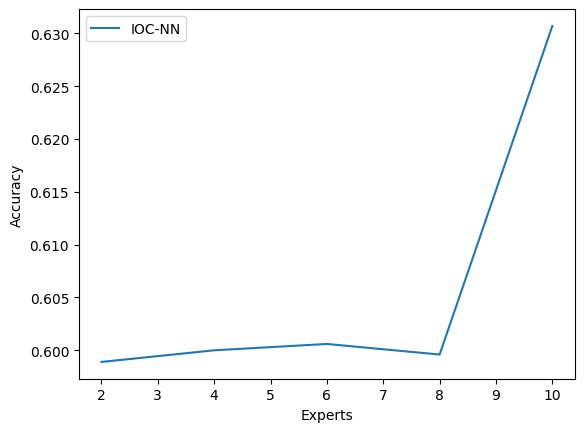

In [53]:
import matplotlib.pyplot as plt

def PlotGraph(X, Y1):
    plt.plot(X, Y1, label = 'IOC-NN')
    # plt.plot(X, Y2, label = "Val")

    plt.xlabel("Experts")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()
X=[2,4,6,8,10]
# observations =[0.7007, 0.6984, 0.7068, 0.6678, 0.6468]
PlotGraph(X,List_observations[1:])

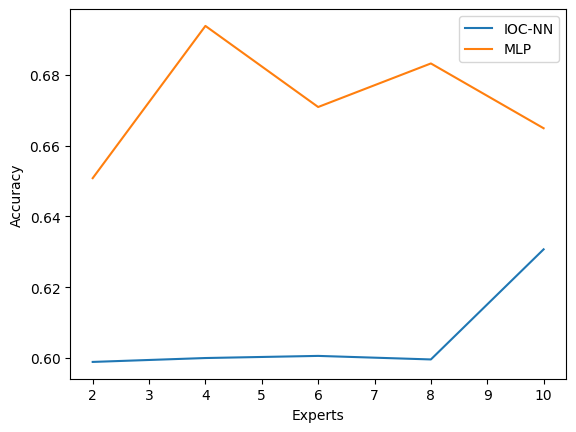

In [54]:
def PlotGraph2(X, Y1,Y2):
    plt.plot(X, Y1, label = 'IOC-NN')
    plt.plot(X, Y2, label = "MLP")

    plt.xlabel("Experts")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()
X=[2,4,6,8,10]
# observations =[0.7007, 0.6984, 0.7068, 0.6678, 0.6468]
observations = [0.6508, 0.6938, 0.6709, 0.6832, 0.6649]
PlotGraph2(X,List_observations[1:],observations)